# Filtering and predicting using the darts filters
In this notebook, we will look at the Kalman filtering algorithm being used to improve the quality of data affected by noise. White noise is a common component in data retrieved from any kind of sensors.

The Kalman filter is a different kind of model in Darts, in that it's a `FilteringModel` (and not a `ForecastingModel`), which can be used to smooth series. In the case of the Kalman filter the "actual" underlying values of the observations are inferred using the state-space model of a linear dynamical system. This system can be provided as an input, or can be fitted on data.

In this notebook, we'll generate a simple synthetic dataset and see how the Kalman filter can be used to denoise it. Note that this is a toy example, mostly to show how the Darts Kalman filter API works.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import KalmanFilter
from darts.utils import timeseries_generation as tg

## Step response of a first order system
A common shape of signal seen in measurements is that of the exponential approach to a steady state, for example in systems converging to a setpoint. We start by preparing the input (control signal) and output, and add noise to obtain realistic observations.

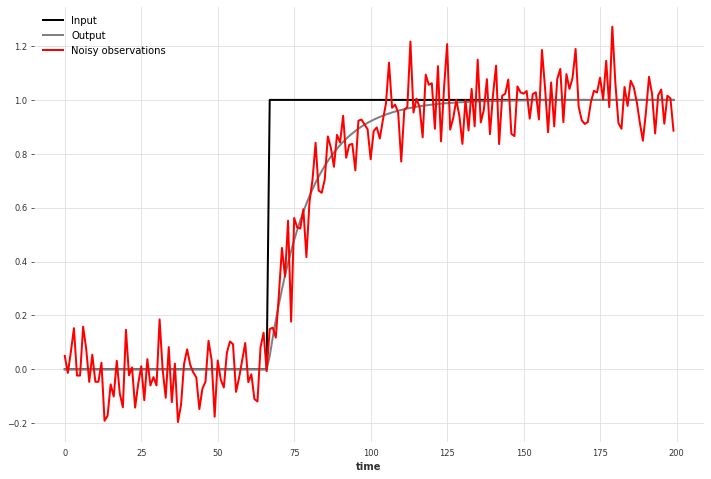

In [2]:
NOISE_DISTANCE = 0.1
SAMPLE_SIZE = 200
np.random.seed(42)

# Prepare the input
u = TimeSeries.from_values(np.heaviside(np.linspace(-5, 10, SAMPLE_SIZE), 0))

# Prepare the output
y = u * TimeSeries.from_values(1 - np.exp(-np.linspace(-5, 10, SAMPLE_SIZE)))

# Add white noise to obtain the observations
noise = tg.gaussian_timeseries(length=SAMPLE_SIZE, std=NOISE_DISTANCE)
y_noise = y + noise

plt.figure(figsize=[12, 8])
u.plot(label="Input")
y.plot(color="gray", label="Output")
y_noise.plot(color="red", label="Noisy observations")
plt.legend()
plt.show()

This behavior can be modeled by a first-order linear dynamical system, making it an ideal candidate for the Kalman filter with `dim_x=1`.

We fit the Kalman filter using the input as covariates, and filter the same time series. Note that the results would probably be better if we had fitted the model on a longer time series.

The filtered observations are fairly close to the noiseless output signal, and tracks the output particularly well at the step change in input. This would not be the case with filtering methods like moving average, and suggests the model indeed takes into account the input (covariates).

We can observe that the error at the start of the time series is larger, as the Kalman filter has little information to estimate the state at that point.

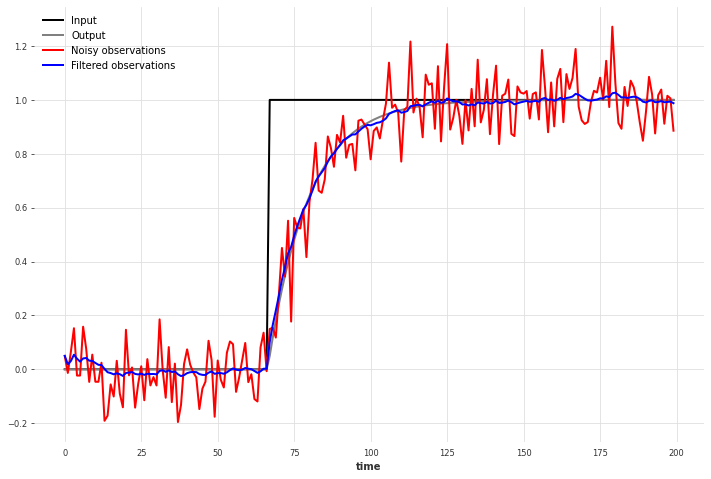

In [3]:
kf = KalmanFilter(dim_x=1)
kf.fit(y_noise, u)
y_filtered = kf.filter(y_noise, u)

plt.figure(figsize=[12, 8])
u.plot(label="Input")
y.plot(color="gray", label="Output")
y_noise.plot(color="red", label="Noisy observations")
y_filtered.plot(color="blue", label="Filtered observations")
plt.legend()

We can also obtain a probabalistic estimate of the underlying value by increasing `num_samples`.

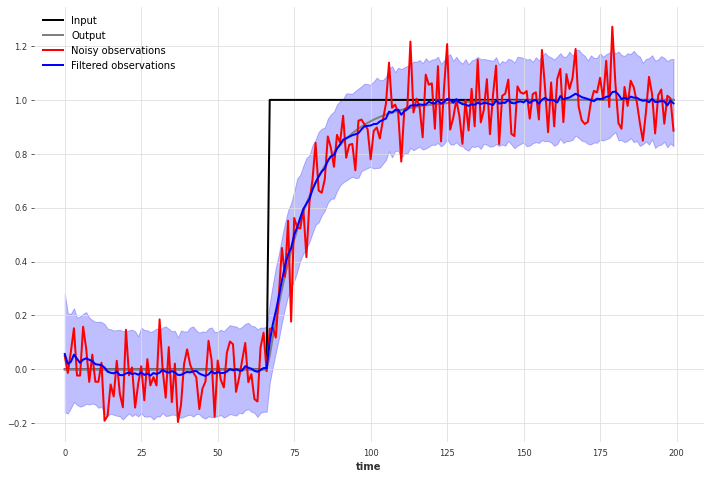

In [4]:
y_filtered = kf.filter(y_noise, u, num_samples=1000)

plt.figure(figsize=[12, 8])
u.plot(label="Input")
y.plot(color="gray", label="Output")
y_noise.plot(color="red", label="Noisy observations")
y_filtered.plot(color="blue", label="Filtered observations")
plt.legend()

## Spiral drawing

First let's produce a simple drawing and add a significant white noise to it.

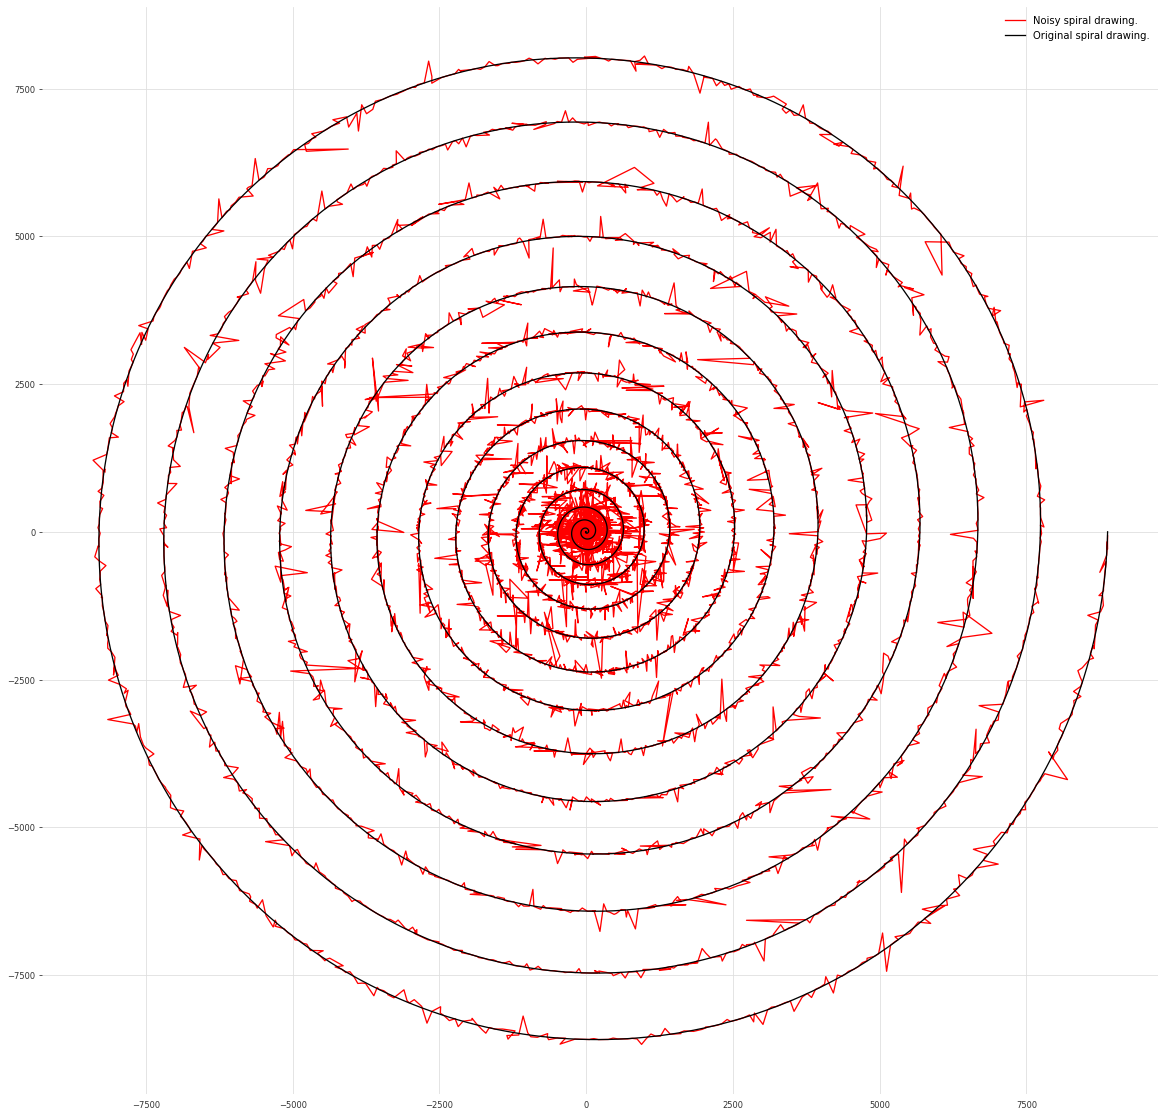

In [5]:
NOISE_DISTANCE = 0.5
SAMPLE_SIZE = 10000
RESIZE_NOISE = 150

# Prepare the drawing
theta = np.radians(np.linspace(360 * 15, 0, SAMPLE_SIZE))
r = theta**2
x_2 = r * np.cos(theta)
y_2 = r * np.sin(theta)

# add white noise (gaussian noise, can be mapped from the random distribution using rand**3)
# and resize to RESIZE_NOISE
x_2_noise = x_2 + (np.random.normal(0, NOISE_DISTANCE, SAMPLE_SIZE) ** 3) * RESIZE_NOISE
y_2_noise = y_2 + (np.random.normal(0, NOISE_DISTANCE, SAMPLE_SIZE) ** 3) * RESIZE_NOISE

plt.figure(figsize=[20, 20])
plt.plot(x_2_noise, y_2_noise, color="red", label="Noisy spiral drawing.")
plt.plot(x_2, y_2, label="Original spiral drawing.")
plt.legend()
plt.show()

The above drawing can be generated using a second order linear dynamical system without input (decaying to its equilibrium at `(0, 0)`). Therefore we can fit a Kalman filter with `dim_x=2` on the multivariate time series containing both the "x" and "y" components. We see that the Kalman filter does a good job at denoising the spiral drawing.

Note that we had to adapt the parameter `num_block_rows` for the model fitting to converge.

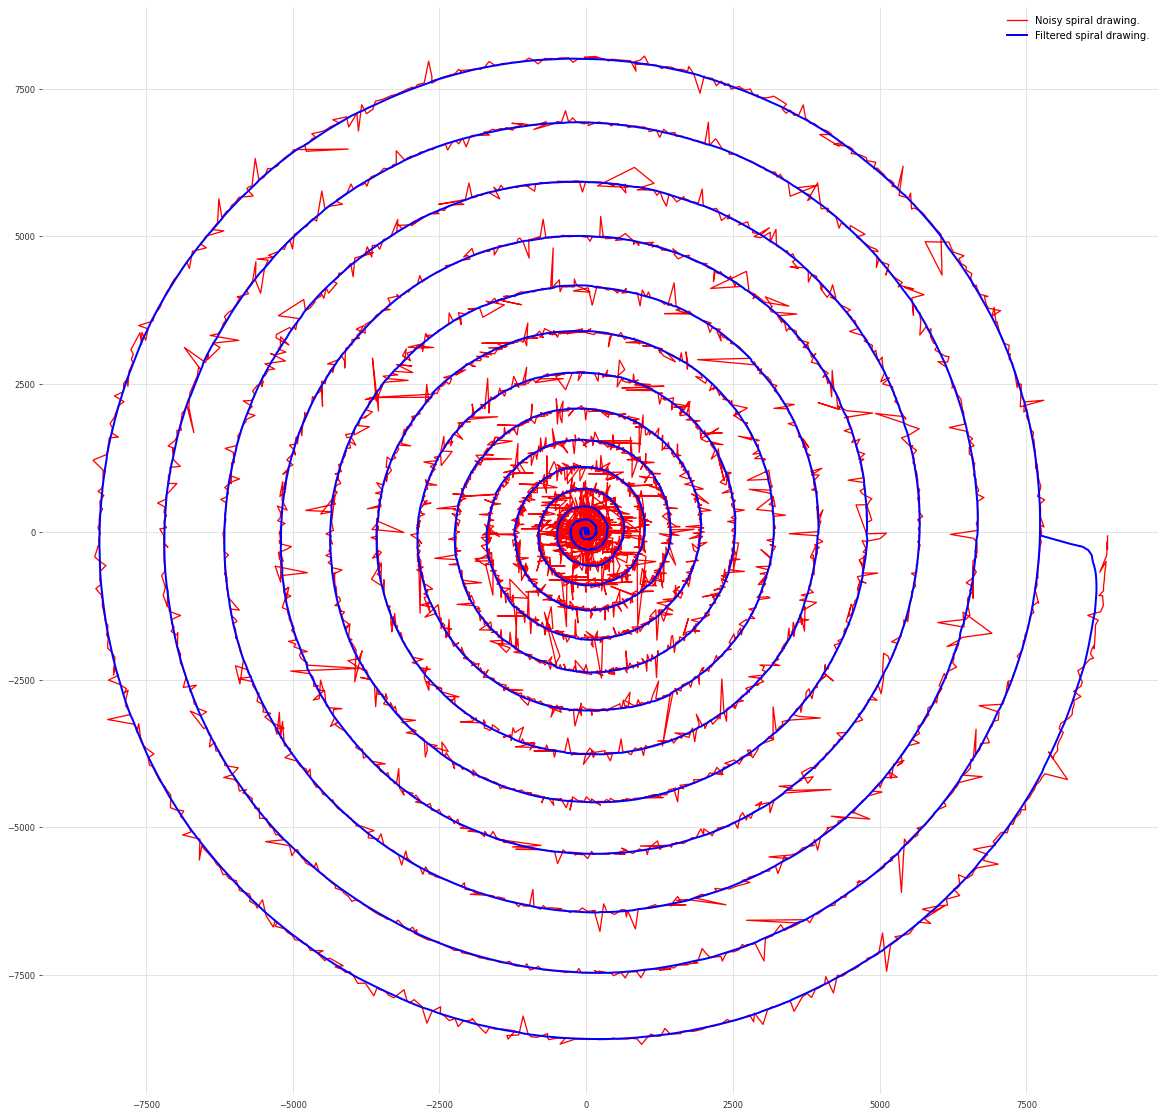

In [6]:
kf = KalmanFilter(dim_x=2)
ts = TimeSeries.from_values(x_2_noise).stack(TimeSeries.from_values(y_2_noise))
kf.fit(ts, num_block_rows=50)

filtered_ts = kf.filter(ts).values()
filtered_x = filtered_ts[:, 0]
filtered_y = filtered_ts[:, 1]

plt.figure(figsize=[20, 20])
plt.plot(x_2_noise, y_2_noise, color="red", label="Noisy spiral drawing.")
plt.plot(
    filtered_x, filtered_y, color="blue", linewidth=2, label="Filtered spiral drawing."
)
plt.legend()